# Building a Simple Quantum Circuit

Before we see an application of quantum machine learning, we'll build a few basic quantum circuits using PennyLane.

In [20]:
import pennylane as qml

After importing the pennylane package, we need to define which quantum device we'll use to execute the circuit. In this example, we'll use `default.qubit`, a simple state simulator of qubit-based quantum circuit architectures. In this first case, we'll only use one qubit, so we set `wires = 1`. 

We define a simple circuit consisting of a Pauli-X gate and a measurement of the expectation value of the Pauli X matrix. 

In [152]:
dev1 = qml.device("default.qubit", wires=1)

@qml.qnode(dev1)
def circuit():
   qml.PauliX(wires=0)
   return qml.expval(qml.PauliZ(0))

After we define our circuit, we can visualize it using the draw function.

In [24]:
print(qml.draw(circuit)())

0: ──X─┤  <Z>


Finally, we can evaluate the circuit by calling the function we've defined.

In [26]:
circuit()

tensor(-1., requires_grad=True)

Recall that the Pauli X gate is the quantum equivalent of a NOT gate, and flips a qubit in state 0 to state 1. Thus, applying two Pauli X gates should be equivalent to not applying any gates at all. 

In [155]:
@qml.qnode(dev1)
def circuit():
   return qml.expval(qml.PauliZ(0))
   
circuit()

tensor(1., requires_grad=True)

In [156]:
@qml.qnode(dev1)
def circuit():
   qml.PauliX(wires=0)
   qml.PauliX(wires=0)
   return qml.expval(qml.PauliZ(0))
   
circuit()

tensor(1., requires_grad=True)

Next we'll create an expressible, entangled quantum circuit. The RX and RY rotation gates take in specified angles, enabling us to explore states around the Bloch sphere, while the Toffoli gate entangles the qubits. We'll return the expectation value of the Pauli Z matrix for all qubits.

In [157]:
dev1 = qml.device("default.qubit", wires=3)
@qml.qnode(dev1)
def circuit(params):
   qml.RX(params[0], wires=0)
   qml.RY(params[0], wires=1)
   qml.Toffoli(wires=[0,1,2])
   return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))

In [160]:
params=[0.1,2.6]
circuit(params)

tensor([0.99500417, 0.99500417, 0.99998752], requires_grad=True)

Next we'll create a circuit using a Hadamard gate. The Hadamard gate maps state 0 to a linear combination of states 0 and 1, with each state having an equal probability of measurement.

In the below circuit, we return the probabilities of each state after the Hadamard gate was applied to an initial state of 0.

In [77]:
dev1 = qml.device("default.qubit", wires=1)

@qml.qnode(dev1)
def circuit():
   qml.Hadamard(wires=0)
   return qml.probs(wires=0)

In [78]:
print(qml.draw(circuit)())

0: ──H─┤  Probs


In [79]:
circuit()

tensor([0.5, 0.5], requires_grad=True)

If the Hadamard gate creates a superposition of states 0 and 1 with equal probability, we should be able to see this by evaluating the circuit many times and measuring the expectation value of an observable like the Pauli Z operator. We can specify the number of times the circuit is evaluated using the shots parameter when we define our device.

In [149]:
dev = qml.device("default.qubit", wires=2, shots=100)

@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    return qml.sample(qml.PauliZ(0))


In [150]:
values = circuit()

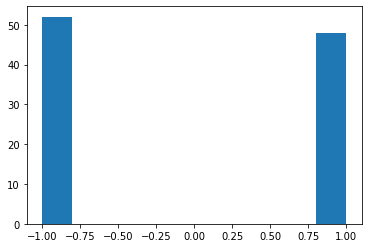

In [151]:
from matplotlib import pyplot as plt 

plt.hist(values)
plt.show()

# Quantum Machine Learning using Covalent

Quantum machine learning typically involves building machine learning algorithms that are a hybrid of quantum and classical components - for example, you may have classical data prepared using classical preprocessing steps, encode that data into a quantum circuit, and use classical machine learning methods to optimize circuit parameters.

In this tutorial, we'll use the quantum approximate optimization algorithm (QAOA) to find an approximate solution to the minimum vertex cover problem. We'll use Covalent to dispatch, organize, and track our computations every step of the way -- culminating in two workflows, each demonstrating a different way of using Covalent for easy experimentation.

## Quantum Approximate Optimization Algorithm 

**QAOA** is an algoithm that can provide approximate solutions to combinatorial optimization problems -- problems aimed at optimmizing some cost function containing a finite set of variables. Many combinatorial optimization problems are NP-hard, making it computationally expensive to find an exact solution. Methods like QAOA get around that by instead finding approximate solutions. QAOA is a simple-to-implement algorithm that can function with little error mitigation and shallow circuit depths, so it is particularly well-suited to be run on NISQ (noisy intermediate-scale quantum) devices.

QAOA problems consist of some bit string *z* and a clause *C*. Each item in the bit string is binary-valued, i.e. $z \in \{0,1\}^n$, where *n* is the total number of bits. The clause $C(z)$ can be represented,
 
$$ C_\alpha= 
\begin{array}{ll}
    1, & \textrm{ if z satisfies clause } C_\alpha \\
    0, & \textrm{ otherwise.} \\
\end{array} $$

The full clause satisfaction problem is treated as the summation over all clauses, $C(z) = \sum_{\alpha = 1}^{m} C_\alpha (z)$, where *m* is the total number of clauses and the *z* in the summand depends on a subset of the bit string.

## The Minimum Vertex Cover Problem

The goal of this vertex cover problem is to find the *minimum* number of vertices needed in order to "cover" all edges in a graph. That is, we want to choose the fewest vertices such that every edge in the graph touches at least one chosen vertex. Determining the minimum vertex cover is an NP-complete problem, meaning that there is no known exact solution that can be found in polynomial time.

In this problem, the bit string *z* consists of all vertices in the graph. A vertex is assigned a value of 1 if it is selected, and a value of 0 if it is not. 

<figure>
  <img src="min_vertex.png" alt="min_vertex" style="width:50%">
  <figcaption>Figure 1: A minimum vertex cover example, where chosen vertices and their associated edges are shown in blue. <i>(a)</i> No vertices are chosen, so no edge is covered. <i>(b)</i> Two vertices are chosen, but not all edges in the graph are covered. <i>(c)</i> Four vertices are chosen and all edges are covered, but this is not the minimum number of vertices to cover all edges. <i>(d)</i> Two vertices are chosen and all edges are covered.</figcaption>
</figure>

In our experiment below, we will use the Python *networkx* package to generate graphs, and minimize the number of chosen vertices.

___
## Implementation 

We begin by importing all necessary packages.

In [1]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

# Covalent
import covalent as ct


## Setting up the Remote Device 


In [2]:
# from covalent.executor import SlurmExecutor

# username = "anna"
# address = "beehive.agnostiq.ai"
# keyfile = "/Users/annahughes/.ssh/beehive_key"
# remote_workdir = "/federation/anna/covalent_workdir"
# poll_freq = 60
# options = {
#     "partition": "debug",
#     "cpus-per-task": 2,
#     "ntasks": 1,
#     "nodelist": "beehive-debug-st-t2medium-1",
#     "chdir": "/federation/anna/covalent_workdir",
# }


In [3]:
# slurm_exec = SlurmExecutor(
#     username=username,
#     address=address,
#     ssh_key_file=keyfile,
#     remote_workdir=remote_workdir,
#     poll_freq=poll_freq,
#     options=options,
# )


___
# Circuit Tasks

To use Covalent, we need to organize our experiment into interdependent tasks, or Python functions. In the language of Covalent, these tasks are called electrons and specified using the `@ct.covalent` decorator. Once we've written and decorated all of our electrons, we write a final function called a lattice, specified with the `@ct.lattice` decorator, that calls all the electrons in order and returns the final result.
For steps that are more computationally heavy and would benefit from remote computational resources, we can call the executor to the desired electron, e.g. `@ct.electron(executor = GPU)`. 

We include the following functions to set up our quantum circuit, compute the cost given the quantum circuit, and update circuit parameters:

- `make_graph`: Generates our graphs for a given number of nodes *n* (determined by the number of qubits) and probability *p* for edge creation at each node. Pennylane returns the QAOA cost and mixer Hamiltonians for the generated graph.

- `get_circuit`: This electron includes two functions. `qaoa_layer` generates the cost and mixer layers given the Hamiltonians defined in the previous step and variational parameters *alpha* and *gamma*. `circuit` creates a quantum circuit from a Hadamard gate and the cost and mixer layers.

- `make_cost_function`: Defines the simulator *dev* and computes the expectation value of the input circuit for a given cost Hamiltonian.

- `get_random_initialization`: Generates two random values between 0 and $2\pi$ from a uniform distribution.

- `initialize_parameters`: Calls all previous functions to create initial values for the cost and mixer Hamiltonians, the resulting circuit, the cost function, the initial angles. Only the cost function and initial angles are returned.

- `calculate_cost`: For an input optimizer, this function computes and returns the value of the cost function and progresses the optimizer by one step, updating the trainable parameters.


We can take a look at graphs generated using the networkx library.

  (-0.25) [Z0]
+ (-0.25) [Z2]
+ (0.5) [Z3]
+ (0.5) [Z1]
+ (0.75) [Z0 Z3]
+ (0.75) [Z1 Z2]
+ (0.75) [Z1 Z3]   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


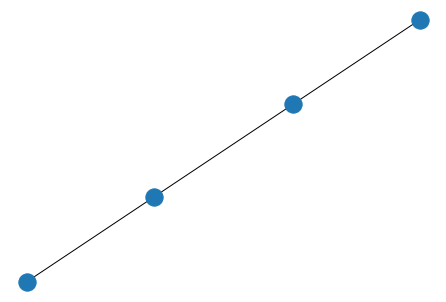

In [4]:
graph = nx.generators.random_graphs.gnp_random_graph(n=4, p=0.5)
nx.draw(graph)
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)
print(cost_h, mixer_h)


We can take a look at what our circuit will look like using the Pennylane qml draw function.

In [27]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)
qubits = 4
qaoa.cost_layer(0, cost_h)
qaoa.mixer_layer(0, mixer_h)

dev = qml.device("lightning.qubit", wires=qubits)


@qml.qnode(dev)
def example_circuit():
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    qaoa.cost_layer(0, cost_h)
    qaoa.mixer_layer(0, mixer_h)
    return qml.expval(cost_h)


print(qml.draw(example_circuit)())


0: ──H─╭ApproxTimeEvolution(0.75,-0.25,0.50,0.75,0.50,-0.25,0.75,0.00)
1: ──H─├ApproxTimeEvolution(0.75,-0.25,0.50,0.75,0.50,-0.25,0.75,0.00)
2: ──H─├ApproxTimeEvolution(0.75,-0.25,0.50,0.75,0.50,-0.25,0.75,0.00)
3: ──H─╰ApproxTimeEvolution(0.75,-0.25,0.50,0.75,0.50,-0.25,0.75,0.00)

──╭ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.00)─┤ ╭<𝓗>
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.00)─┤ ├<𝓗>
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.00)─┤ ├<𝓗>
──╰ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.00)─┤ ╰<𝓗>


In [6]:
@ct.electron
def make_graph(qubits, prob):
    graph = nx.generators.random_graphs.gnp_random_graph(n=qubits, p=prob)
    cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)
    return cost_h, mixer_h


@ct.electron
def get_circuit(cost_h, mixer_h):
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)

    def circuit(params, wires, **kwargs):
        depth = params.shape[1]
        for w in range(wires):
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, depth, params[0], params[1])

    return circuit


@ct.electron
def make_cost_function(circuit, cost_h, qubits):
    dev = qml.device("lightning.qubit", wires=qubits)

    @qml.qnode(dev)
    def cost_function(params):
        circuit(params, wires=qubits)
        return qml.expval(cost_h)

    return cost_function


@ct.electron
def get_random_initialization(p=1):
    return np.random.uniform(0, 2 * np.pi, (2, p), requires_grad=True)


@ct.electron
def initialize_parameters(p=1, qubits=2, prob=0.3):
    cost_h, mixer_h = make_graph(qubits=qubits, prob=prob)
    circuit = get_circuit(cost_h, mixer_h)
    cost_function = make_cost_function(circuit, cost_h, qubits)
    initial_angles = get_random_initialization(p=p)
    print(initial_angles)
    return cost_function, initial_angles


@ct.electron
def calculate_cost(cost_function, params, optimizer):
    params, loss = optimizer.step_and_cost(cost_function, params)
    return optimizer, params, loss


The final two functions in our workflow contain the optimization and post-processing step:

- `optimize_electron`: initializes parameters, iterates through the optimization process, and returns the loss of each iteration
- `collect_and_mean`: a simple electron to return the mean value of an array

In [7]:
@ct.electron
# @ct.electron(executor=slurm_exec)
def optimize_electron(
    cost_function, init_angles, optimizer=qml.GradientDescentOptimizer(), iterations=10
):
    loss_history = []
    params = init_angles
    for _ in range(iterations):
        optimizer, params, loss = calculate_cost(
            cost_function=cost_function, params=params, optimizer=optimizer
        )
        loss_history.append(loss)
    return loss_history


@ct.electron
def collect_and_mean(array):
    return np.mean(array, axis=0)


## The run_exp Workflow

Running this lattice makes the most sense if you're uninterested in saving your intermediate optimization steps, as opposed to the `optimize` lattice, which will come later. In this case, the optimization is performed *within* the `optimize_electron` task, so only the final output of that electron - the loss history - is saved. This is ideal for running simulations.

As the number of iterations in `optimize_electron` increases, the runtime will get long, so this particular electron is sent to a remote device for faster computation.

In [8]:
@ct.lattice
def run_exp(
    p=1, qubits=2, prob=0.3, optimizers=[qml.GradientDescentOptimizer()], iterations=10
):
    compare_optimizers = []
    tmp = []
    cost_function, init_angles = initialize_parameters(p=p, qubits=qubits, prob=prob)
    for optimizer in optimizers:
        loss_history = optimize_electron(
            cost_function=cost_function,
            init_angles=init_angles,
            optimizer=optimizer,
            iterations=iterations,
        )
        tmp.append(loss_history)
    compare_optimizers.append(tmp)
    return collect_and_mean(compare_optimizers)


We can visualize the `run_exp` workflow on the Covalent UI once we've dispatched it. It automatically generates a directed acyclic graph, or DAG, showing the relationships between all electrons in the workflow.
![run_exp_dag](run_exp_dag.png)

___
## Dispatching the Workflow

Since we've imported `covalent` as `ct`, we can use the dispatch syntax in order to dispatch our workflow. We have already specified the electrons to be sent to the SLURM executor in the electron decorators, so there is no need to specify a device when dispatching the workflow.

In [9]:
id = ct.dispatch(run_exp)(
    p=1, qubits=2, prob=0.3, optimizers=[qml.GradientDescentOptimizer()], iterations=100
)

We can see our results below - we retrieve our results using the `ct.get_result` method, specifying the dispatch id set above and letting wait=True to wait for the workflow to finish. The `run_exp` workflow is set up to take a list of optimizers and compute the mean loss value, but when we dispatched our workflow we only included the Pennylane GradientDescentOptimizer.

We plot the loss values as a function of iterations - as expected, with more iterations the loss decreases.

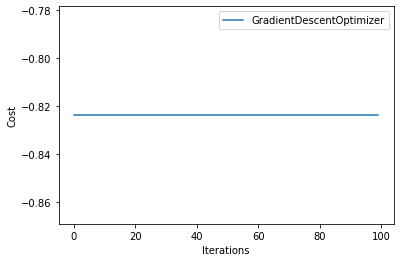

In [10]:
result = ct.get_result(id, wait=True)
result = result.result
for i in range(len(result)):
    plt.plot(np.array(result[i]).T, label="GradientDescentOptimizer")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()


## Investigating Optimizer Performance

One of the benefits of organizing your code into a workflow is the ease of rapid prototyping and experimentation. For example, the `optimize_electron` function allows you to modify the initial angles and optimizer used in the optimization process.

Pennylane offers a number of different optimizers in addition to the GradientDescentOptimizer that use various methods to navigate the cost landscape. An optimizer will automatically update problem parameters as they minimize the value of the cost function. Below, we examine four different Pennylane optimizers to see which one best minimizes our cost function.

In [11]:
optimizers = [
    qml.GradientDescentOptimizer(),
    qml.AdagradOptimizer(),
    qml.MomentumOptimizer(),
    qml.AdamOptimizer(),
]
id = ct.dispatch(run_exp)(
    p=1, qubits=2, prob=1.2, seed=[1], optimizers=optimizers, iterations=100
)


The below result runs the `run_exp` for each optimizer in our list

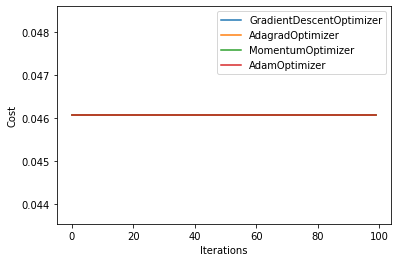

In [12]:
result = ct.get_result(id, wait=True)
result = result.result
simulators = [
    "GradientDescentOptimizer",
    "AdagradOptimizer",
    "MomentumOptimizer",
    "AdamOptimizer",
]
for i in range(len(result)):
    plt.plot(np.array(result[i]).T, label=simulators[i])
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()


___

## The Optimize Workflow

In actual quantum computing runs, each iteration in the optimization process is costly both in time and resources - so we might want to monitor our optimization process at each iteration. Unlike the `run_exp` workflow, where optimization done in an electron, the `Optimize` workflow contains the optimization within the lattice itself.
The downside of structuring the workflow this way is that it can take much longer if it is sent to actual quantum devices due to queues.

In [13]:
@ct.lattice  # (executor=dask)
def optimize(
    p=1, qubits=2, prob=0.3, optimizers=[qml.GradientDescentOptimizer()], iterations=10
):
    compare_optimizers = []
    for optimizer in optimizers:
        loss_history = []
        cost_function, init_angles = initialize_parameters(
            p=p, qubits=qubits, prob=prob
        )
        params = init_angles
        alpha_list = []
        beta_list = []
        for _ in range(iterations):
            optimizer, params, loss = calculate_cost(
                cost_function=cost_function, params=params, optimizer=optimizer
            )
            loss_history.append(loss)
            alpha_list.append(params[0])
            beta_list.append(params[1])
        compare_optimizers.append(loss_history)
    return compare_optimizers, alpha_list, beta_list


We can again visualize our workflow from the Covalent UI.
![optimize_dag](optimize_dag.png)

In [14]:
iterations = 10
p = 1
qubits = 1
prob = 0.6
optimizers = [
    qml.GradientDescentOptimizer(),
    qml.AdagradOptimizer(),
    qml.MomentumOptimizer(),
]
id = ct.dispatch(optimize)(
    p=p, qubits=qubits, prob=prob, iterations=iterations, optimizers=optimizers
)


___
## Comparing Optimizer Results

As before, we compare the loss as the number of iterations is increased.

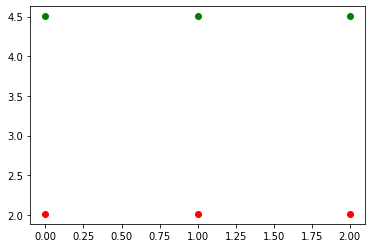

In [15]:
result = ct.get_result(id, wait=True)
alpha = result.result[1]
beta = result.result[2]
for i in range(len(alpha)):
    plt.scatter(i, alpha[i], color="red")
    plt.scatter(i, beta[i], color="green")
plt.show()


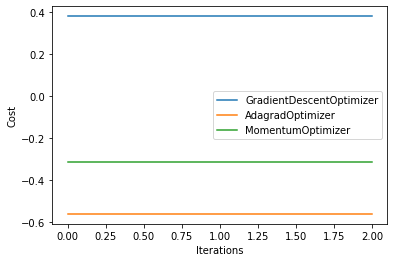

In [16]:
result = ct.get_result(id, wait=True)
result = result.result[0]
for i in range(len(result)):
    plt.plot(np.array(result[i]).T, label=simulators[i])
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()


____ 

# Coding Challenge: Plot the cost vs iterations for a range of different initial angles

In this challenge, we want to explore how the initial values of the angles passed into the circuit impact the optimization process. The initial values should range between 0 and $2 \pi$, and include at least a few samples within that range. As we saw when comparing the performance of different optimizers, you should create a plot with cost on the y-axis and number of iterations on the x-axis, where different lines are plotted showing the optimization of different angles explored.

Feel free to make edits to both electrons and to the lattice.


___

## Our Solution

There are many different ways to implement this, both within and outside the lattice. In our solution, we explore four angle ranges between 0 and $2\pi$: 0 to $\frac{\pi}{2}$, $\frac{\pi}{2}$ to $\pi$, $\pi$ to $\frac{3}{2} \pi$, and $\frac{3}{2} \pi$ to $2 \pi$. This involved making edits to the `get_random_initialization` and `initialize_parameters` functions: in the first case, we modify the range of values used to initialize angles and in the latter case we call the `get_random_initialization` function. 

In [17]:
@ct.electron
def get_random_initialization(p=1, lower_l=0, higher_l=2 * np.pi):
    return np.random.uniform(lower_l, higher_l, (2, p), requires_grad=True)


@ct.electron
def initialize_parameters(p=1, qubits=2, prob=0.3, lower_l=0, higher_l=2 * np.pi):
    cost_h, mixer_h = make_graph(qubits=qubits, prob=prob)
    circuit = get_circuit(cost_h, mixer_h)
    cost_function = make_cost_function(circuit, cost_h, qubits)
    initial_angles = get_random_initialization(p=p, lower_l=lower_l, higher_l=higher_l)
    return cost_function, initial_angles


In [18]:
@ct.lattice  # (executor=dask)
def run_exp(
    p=1,
    qubits=2,
    prob=0.3,
    optimizers=[qml.GradientDescentOptimizer()],
    iterations=10,
    limits=[[0, 2 * np.pi]],
):
    compare_optimizers = []
    tmp = []
    for lower_l, higher_l in limits:
        cost_function, init_angles = initialize_parameters(
            p=p, qubits=qubits, prob=prob, lower_l=lower_l, higher_l=higher_l
        )
        for optimizer in optimizers:
            loss_history = optimize_electron(
                cost_function=cost_function,
                init_angles=init_angles,
                optimizer=optimizer,
                iterations=iterations,
            )
            tmp.append(loss_history)
    compare_optimizers.append(tmp)
    return compare_optimizers


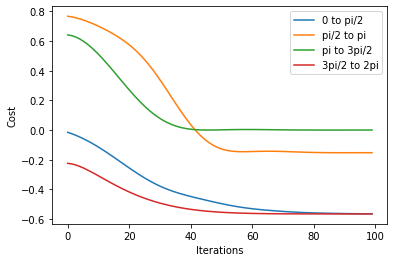

In [19]:
limits = [
    [0, np.pi / 2],
    [np.pi / 2, np.pi],
    [np.pi, np.pi * 1.5],
    [np.pi * 1.5, 2 * np.pi],
]
optimizers = [qml.AdamOptimizer()]

labels = ["0 to pi/2", "pi/2 to pi", "pi to 3pi/2", "3pi/2 to 2pi"]

local_result = run_exp(
    p=1, qubits=2, prob=1.2, optimizers=optimizers, iterations=100, limits=limits
)

for i in range(len(local_result[0])):
    plt.plot(np.array(local_result[0][i]).T, label=labels[i])
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()
